In [30]:
# standard library
import os
from os import path
import sys
_path = path.abspath('../pkg/')
if _path not in sys.path:
    sys.path.append(_path)
import pickle

# Third-party
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table, join
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import UnitSystem

import emcee
from pyia import GaiaData

from chemtrails.potential import Sech2Potential, UniformPotential
from chemtrails.likelihood import Model
from chemtrails.data import load_nominal_galah, load_nominal_apogee, get_abundance_data

In [2]:
usys = UnitSystem(u.pc, u.Myr, u.Msun, u.radian, u.km/u.s)

# GALAH

In [32]:
g, galcen = load_nominal_galah('/Users/adrian/data/GaiaDR2/GALAH-GaiaDR2-xmatch.fits',
                               zlim=1*u.kpc, vlim=50*u.km/u.s)
survey = 'galah'

snr_lim = 32
mask = (g.snr_c1 > snr_lim) & (g.snr_c2 > snr_lim) & (g.snr_c3 > snr_lim)
g = g[mask]
galcen = galcen[mask]
len(g)

27328

# APOGEE

In [33]:
# g, galcen = load_nominal_apogee('/Users/adrian/data/GaiaDR2/Gaia_Apogee_RC_Crossmatch_all.fits',
#                                 zlim=1*u.kpc, vlim=50*u.km/u.s)
# survey = 'apogee-rc'

# mask = (g.Classification == 'RC_Pristine')
# g = g[mask]
# galcen = galcen[mask]

# len(g)

### Quick model test:

In [34]:
model = Model(galcen, g, ['fe_h'])
model([60., 0., np.log(65), np.log(250)])

-16588.708393526482

---

## Emcee

In [35]:
import corner
from schwimmbad import MultiPool, SerialPool

In [36]:
p0 = np.array([0., 0., np.log(65.), np.log(400.)])

nburn = 256
nsteps = 256
nwalkers = 64

ndim = len(p0)
p0 = emcee.utils.sample_ball(p0, std=[1e-2]*ndim, size=nwalkers)

  0%|          | 0/256 [00:00<?, ?it/s]

burn-in


  0%|          | 0/256 [00:00<?, ?it/s]

sampling


100%|██████████| 256/256 [00:20<00:00,  9.55it/s]


[ -7.96891322e-04   7.80089005e-04   4.17404604e+00   5.99300219e+00]


  0%|          | 0/256 [00:00<?, ?it/s]

burn-in


  0%|          | 0/256 [00:00<?, ?it/s]

sampling


100%|██████████| 256/256 [00:23<00:00, 10.85it/s]


[ -7.96891322e-04   7.80089005e-04   4.17404604e+00   5.99300219e+00]


  0%|          | 0/256 [00:00<?, ?it/s]

burn-in


  0%|          | 0/256 [00:00<?, ?it/s]

sampling


100%|██████████| 256/256 [00:17<00:00, 16.02it/s]


[ -7.96891322e-04   7.80089005e-04   4.17404604e+00   5.99300219e+00]


  0%|          | 0/256 [00:00<?, ?it/s]

burn-in


  0%|          | 0/256 [00:00<?, ?it/s]

sampling


100%|██████████| 256/256 [00:20<00:00,  9.90it/s]


[ -7.96891322e-04   7.80089005e-04   4.17404604e+00   5.99300219e+00]


  0%|          | 0/256 [00:00<?, ?it/s]

burn-in


  0%|          | 1/256 [00:00<00:27,  9.34it/s]

sampling


100%|██████████| 256/256 [00:26<00:00,  9.07it/s]


[ -7.96891322e-04   7.80089005e-04   4.17404604e+00   5.99300219e+00]


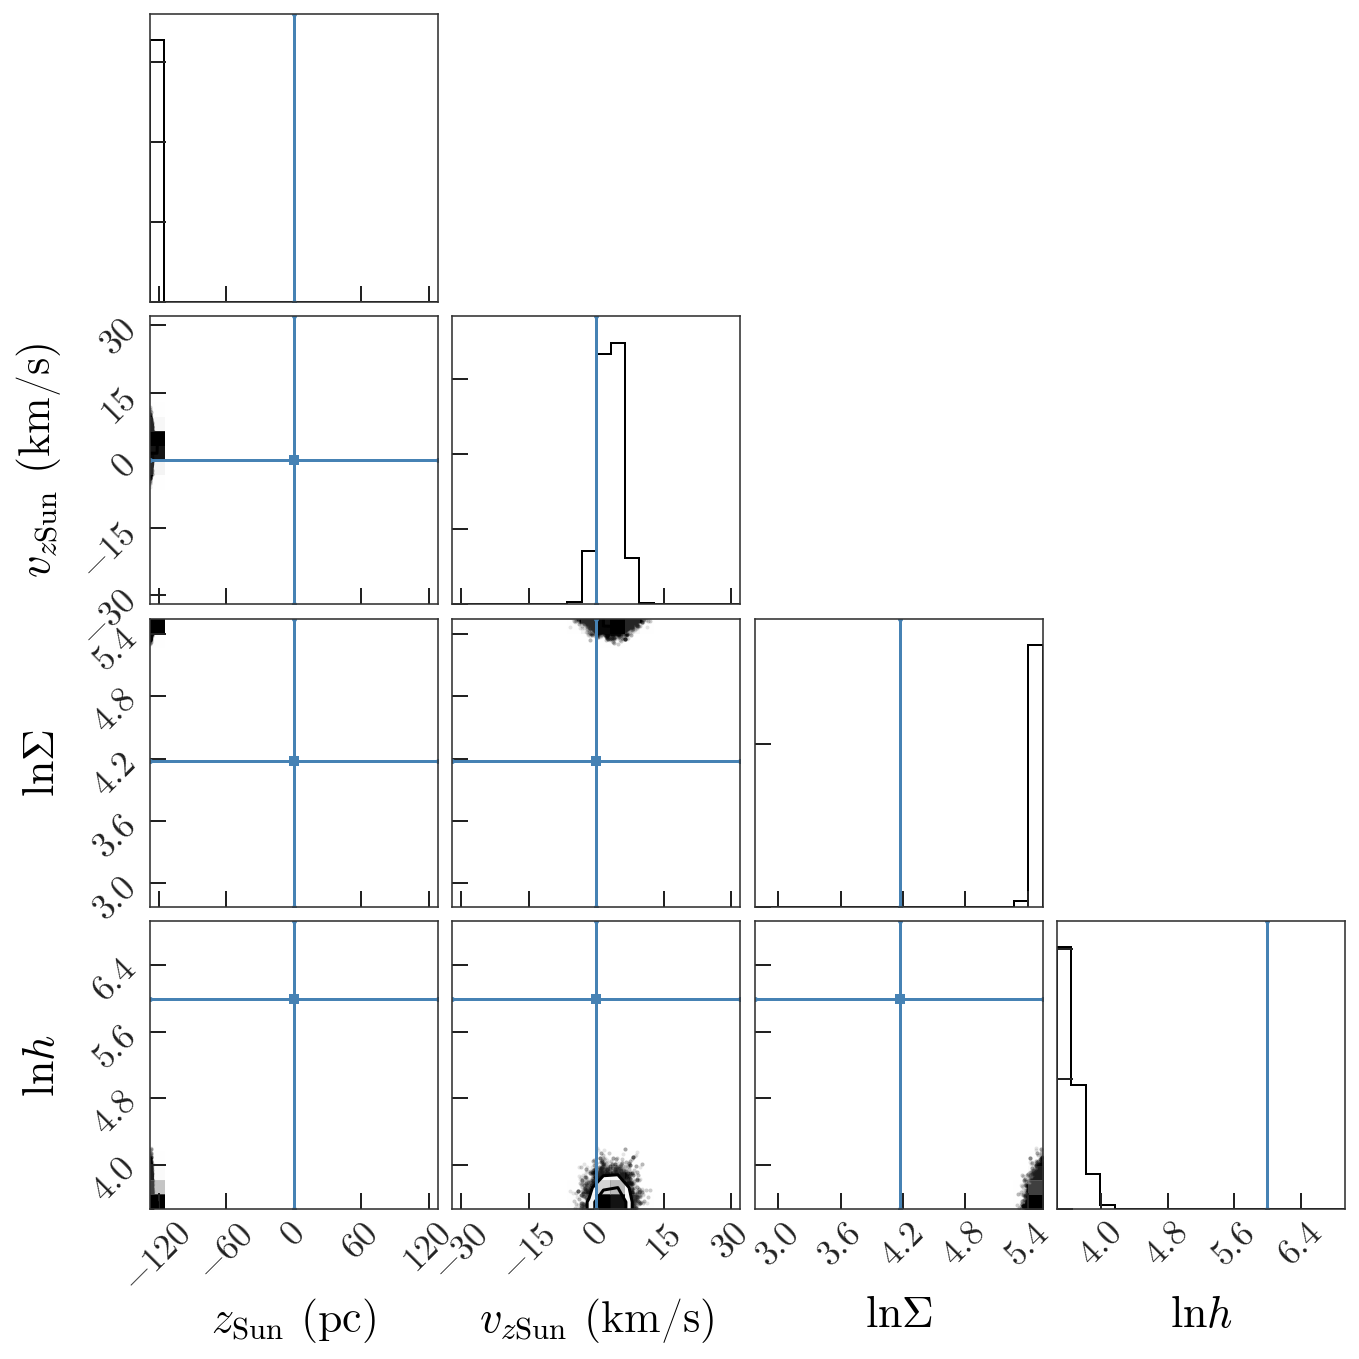

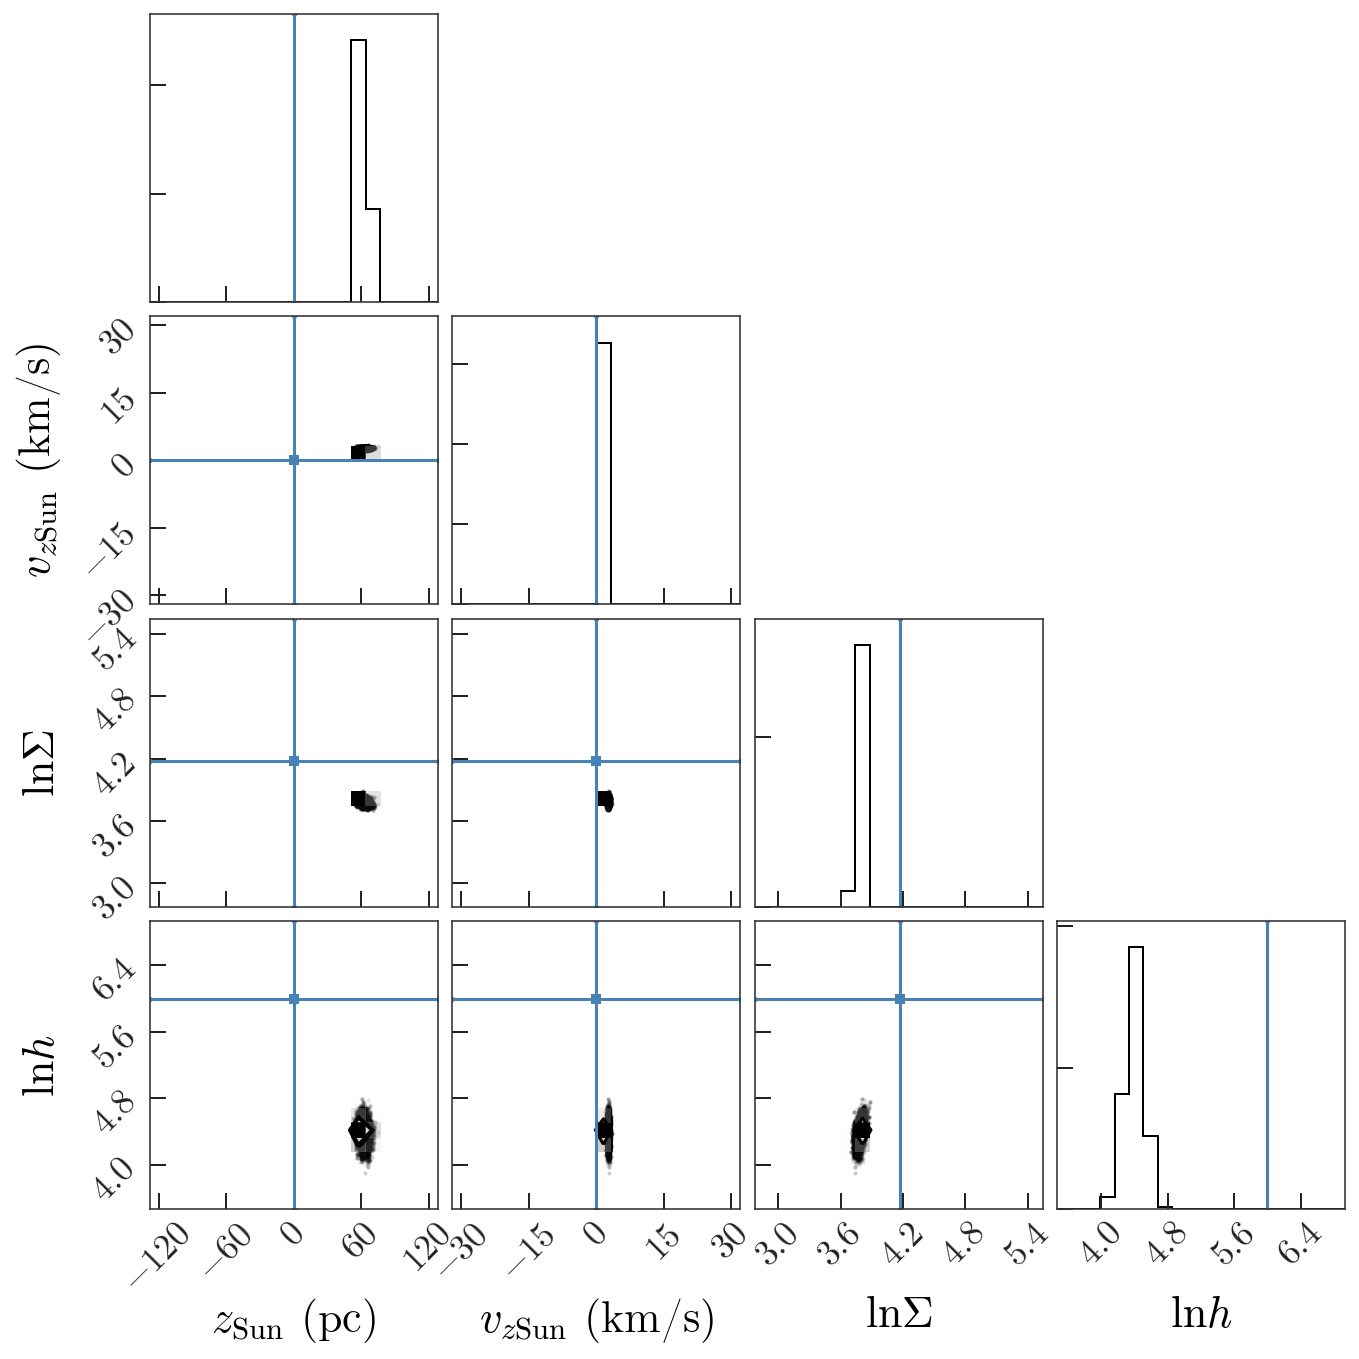

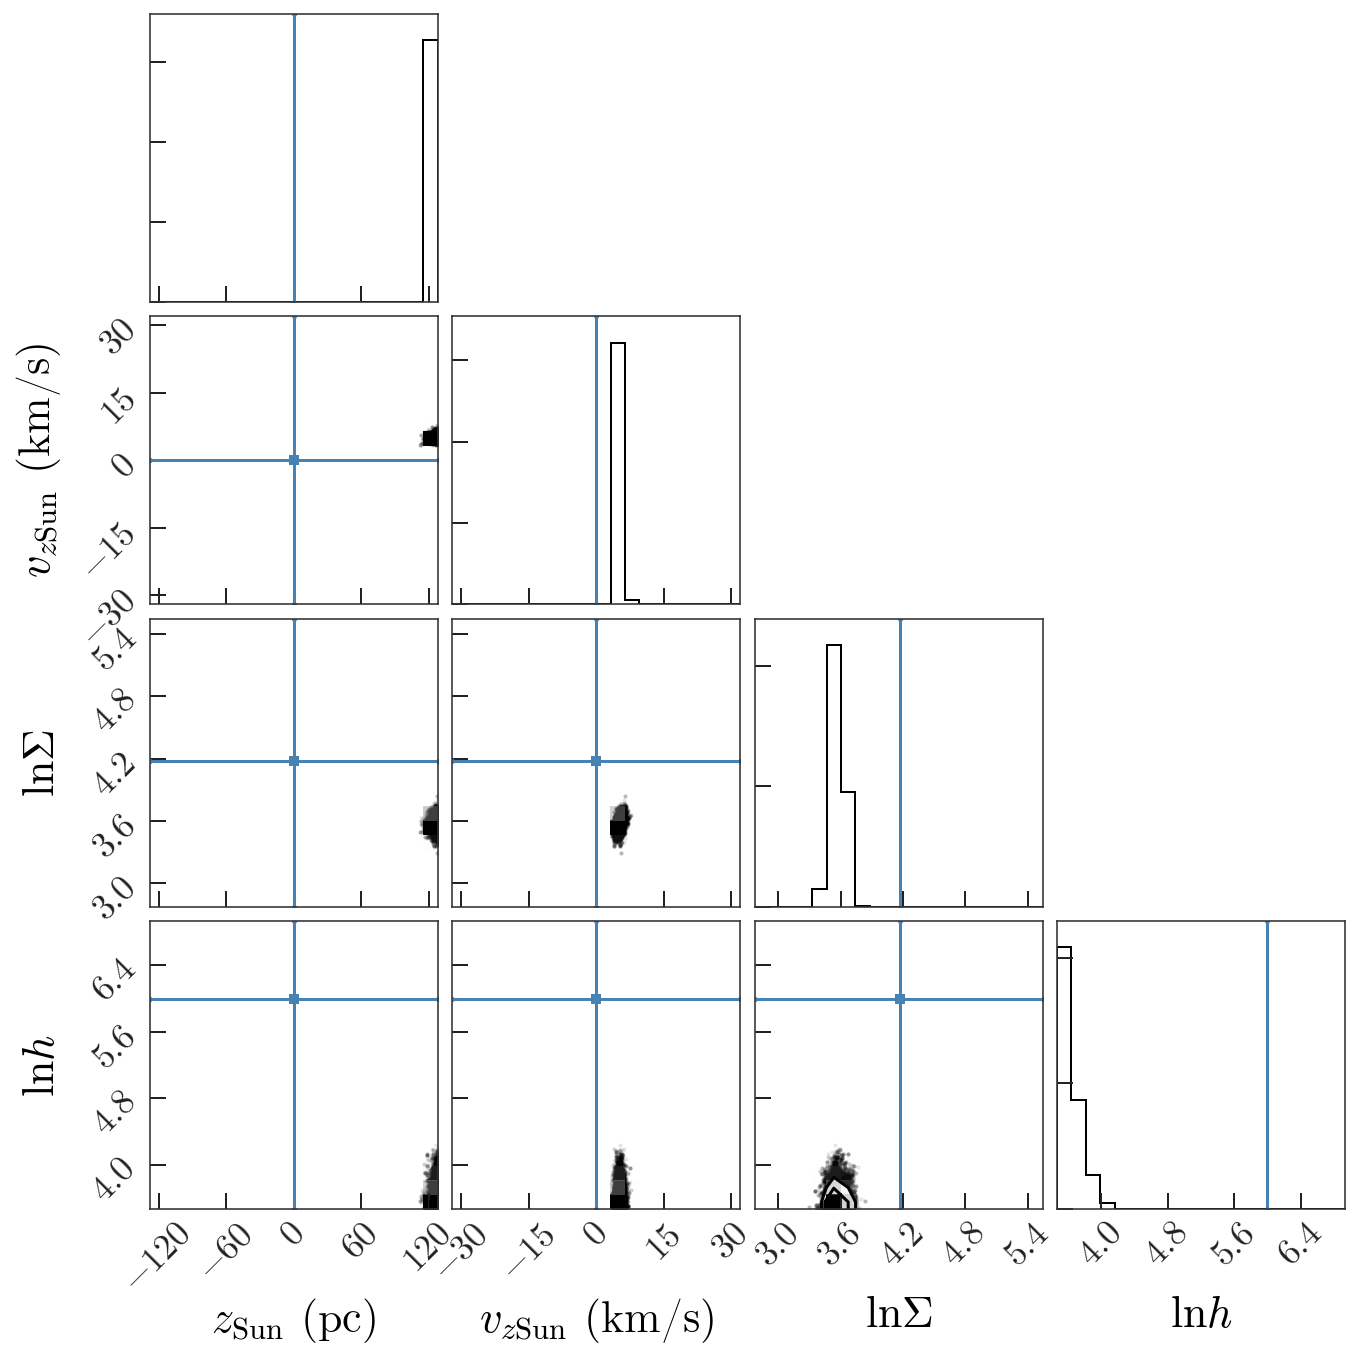

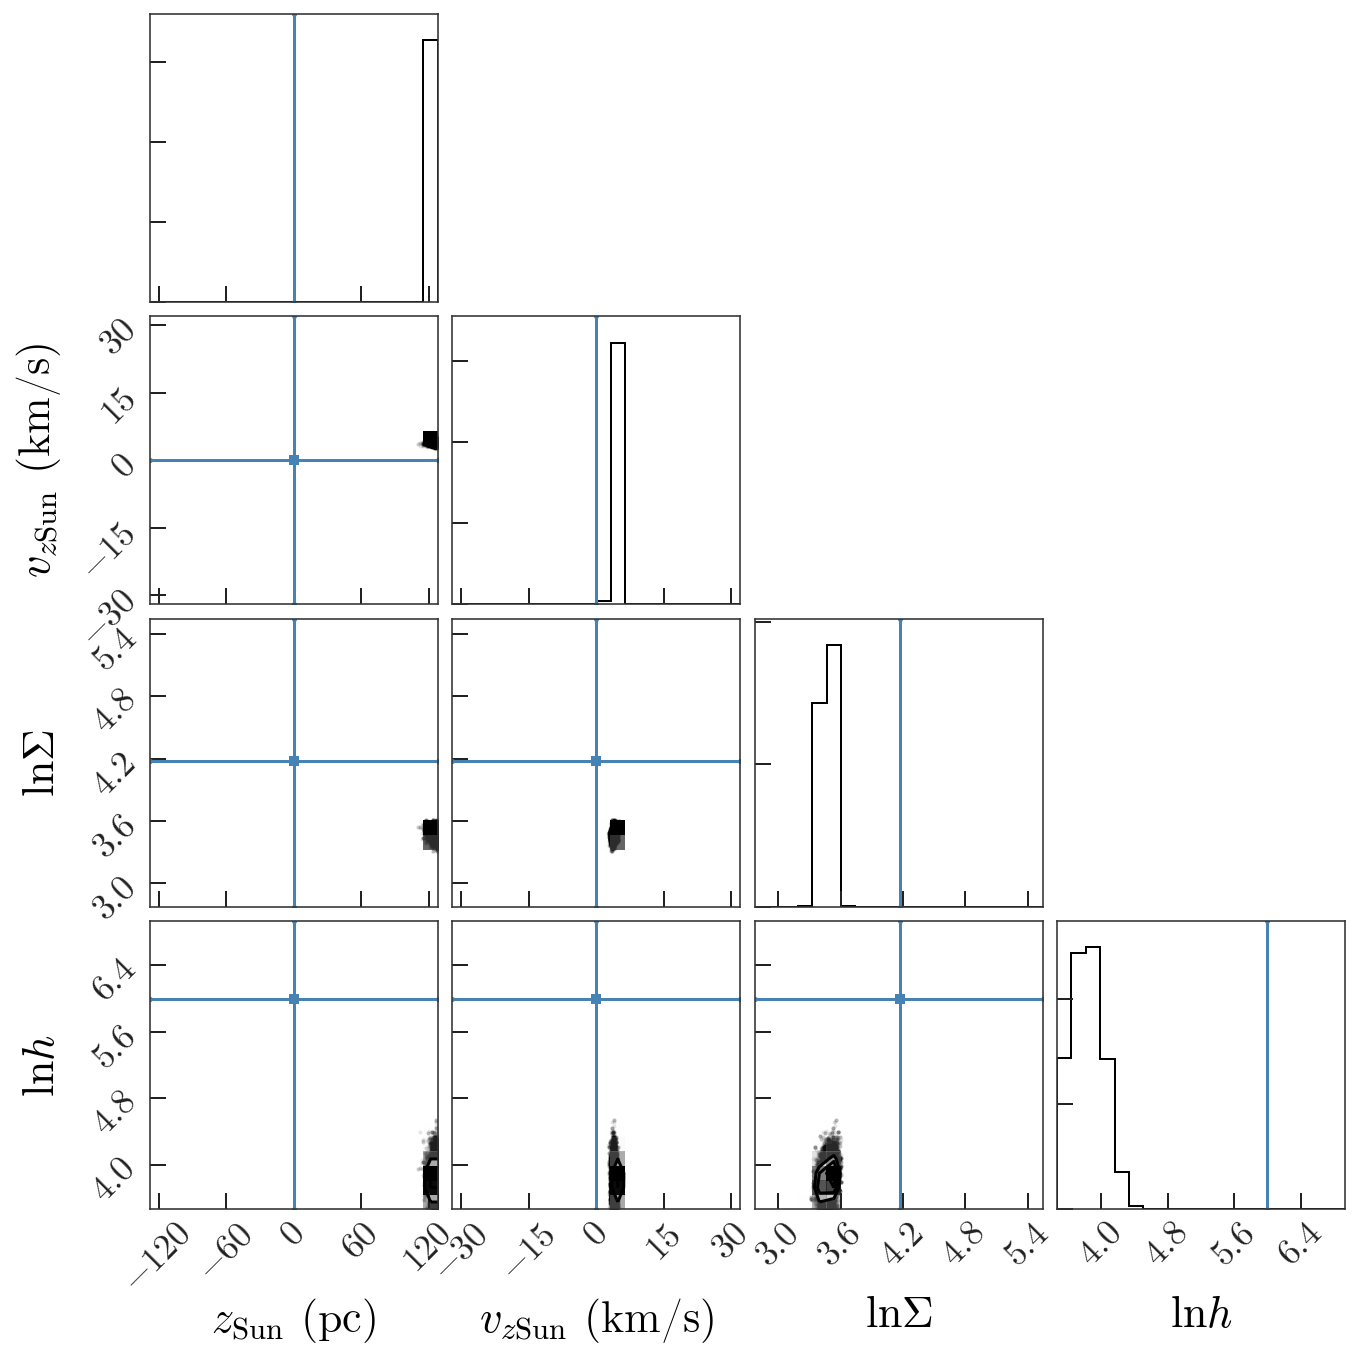

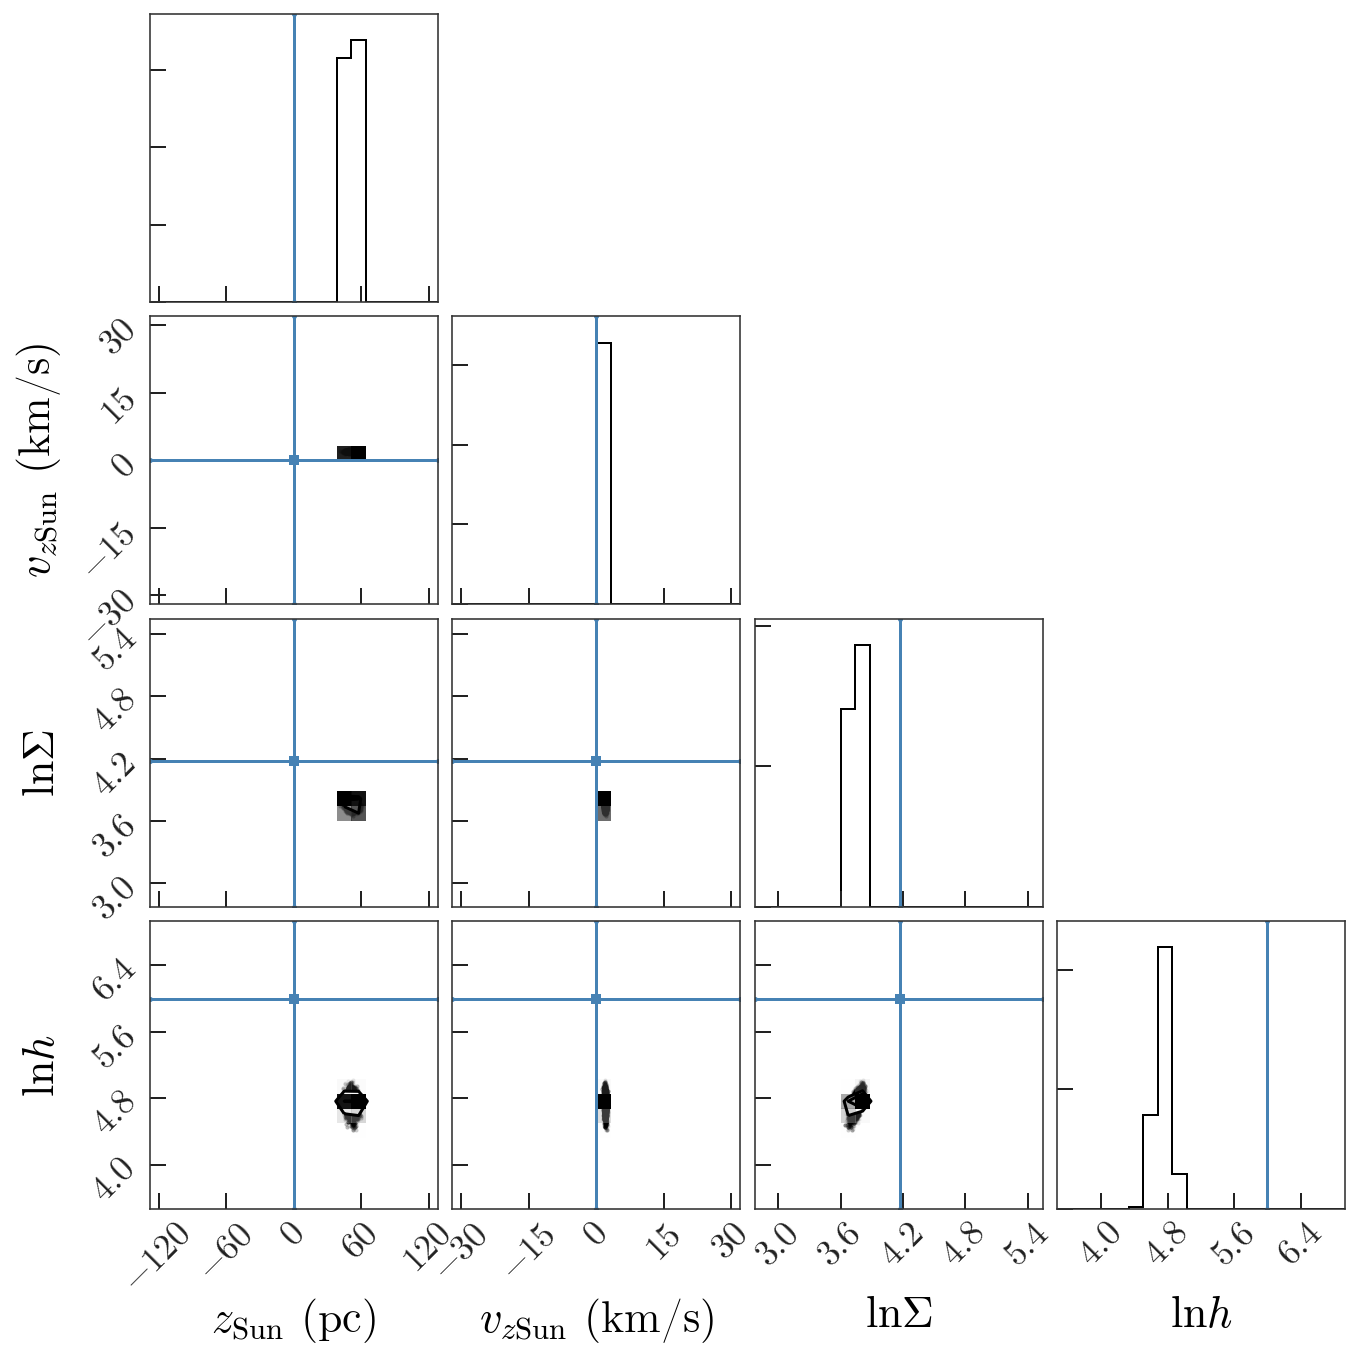

In [37]:
elems = [['o_h'], 
         ['fe_h'], 
         ['mg_h'], 
         ['al_h'],
         ['na_h']]
# elems = elems + [np.ravel(elems).tolist()]

if not path.exists(survey):
    os.makedirs(survey)

for elem in elems:
    name = '_'.join(sorted(elem))
    cache_filename = path.join(survey, 'sampler-{0}.pkl'.format(name))
    
    if not path.exists(cache_filename):
        model = Model(galcen, g, elem)

        with SerialPool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, model, 
                                            pool=pool)

            print("burn-in")
            pos, prob, state = sampler.run_mcmc(p0.copy(), nburn, progress=True)

            print("sampling")
            sampler.reset()
            _ = sampler.run_mcmc(pos, nsteps, progress=True)
        
        with open(cache_filename, 'wb') as f:
            pickle.dump(sampler, f)
            
    with open(cache_filename, 'rb') as f:
        sampler = pickle.load(f)
    
    print(np.mean(p0, axis=0))
    fig = corner.corner(sampler.flatchain, 
                        labels=[r"$z_\mathrm{Sun}$ (pc)",
                                r"$v_{z\mathrm{Sun}}$ (km/s)",
                                r"$\ln\Sigma$",
                                r"$\ln h$", ],
                        range=[[-128, 128.],
                               [-32., 32.],
                               [np.log(16.), np.log(256.)],
                               [np.log(32.), np.log(1024.)]],
                        truths=np.mean(p0, axis=0)) 
    fig.savefig(path.join(survey, 'corner-{0}.png'.format(name)), dpi=200)

# Likelihood slice

In [12]:
model = Model(galcen, g, ['fe_h'])

Text(0.5,0,'$\\ln \\Sigma$')

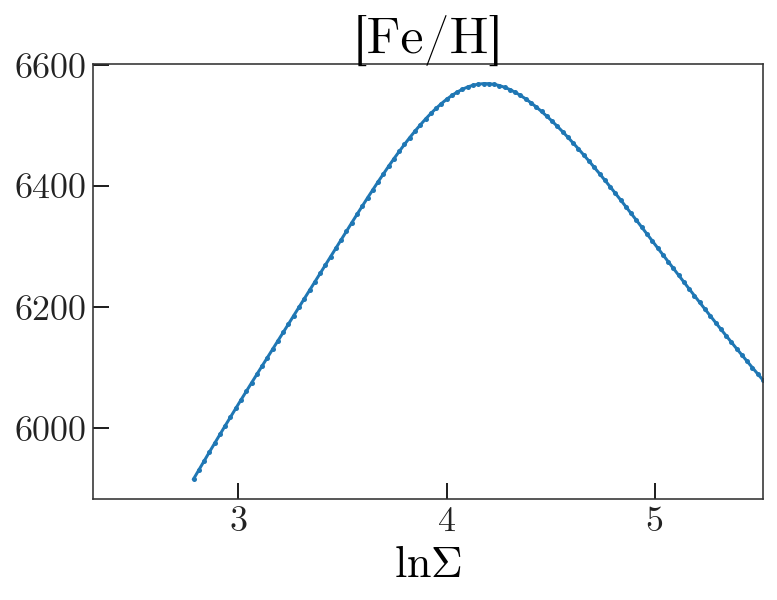

In [14]:
lns_grid = np.linspace(np.log(10), np.log(250), 128)
lls = np.zeros_like(lns_grid)

for i in range(len(lns_grid)):
    p = [0., 0., lns_grid[i], np.log(250)]
    lls[i] = model(p) # CHANGE THIS TO YOUR ln_likelihood CALL!
    
plt.plot(lns_grid, lls)
plt.xlim(lns_grid.min(), lns_grid.max())
plt.title('[Fe/H]')
plt.xlabel(r'$\ln \Sigma$')

Text(0.5,0,'$\\Sigma$')

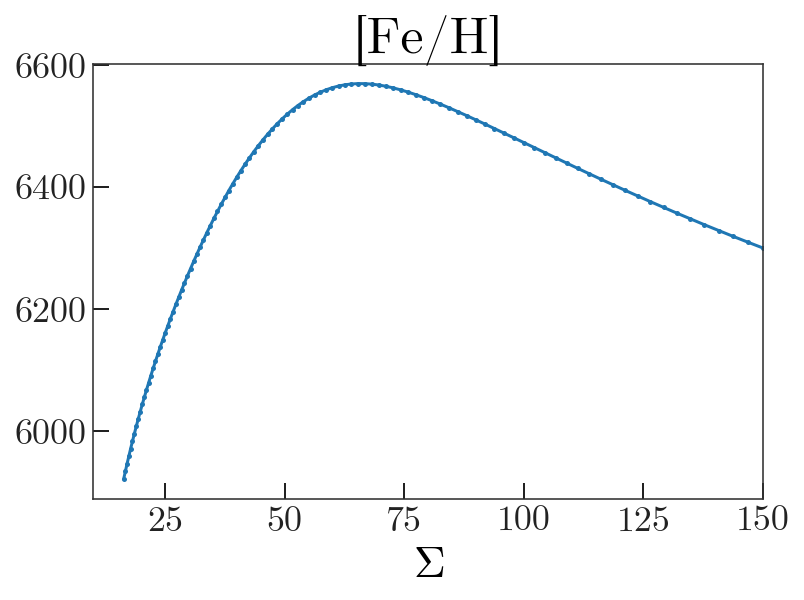

In [15]:
lns_grid = np.linspace(np.log(10), np.log(150), 128)
lls = np.zeros_like(lns_grid)

for i in range(len(lns_grid)):
    p = [0, 0., lns_grid[i], np.log(250)]
    lls[i] = model(p) # CHANGE THIS TO YOUR ln_likelihood CALL!
    
plt.plot(np.exp(lns_grid), lls)
plt.xlim(np.exp(lns_grid.min()), np.exp(lns_grid.max()))
plt.title('[Fe/H]')
plt.xlabel(r'$\Sigma$')

## Profiling

In [10]:
%load_ext line_profiler

In [11]:
%timeit model.ln_posterior(np.array([0., 0., np.log(65.), np.log(400.)]))

2.49 ms ± 316 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
# %lprun -f model.ln_metal_likelihood model.ln_posterior(np.array([0., 0., np.log(65.), np.log(400.)]))

### Wassup with [Fe/H]?

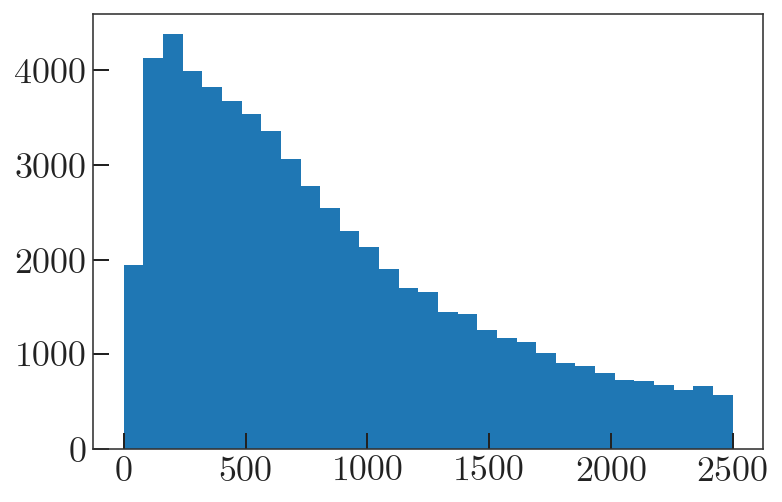

In [7]:
pot0 = Sech2Potential(Sigma=65*u.Msun/u.pc**2,
                      hz=250*u.pc, units=usys)
Ez = 0.5*galcen.v_z**2 + pot0.energy(galcen.z[None])
plt.hist(Ez.value, bins=np.linspace(0, 2500, 32));

In [18]:
# BROKEN
# bins = np.linspace(0, 2000, 8)
# cmap = plt.get_cmap('viridis')
# norm = mpl.colors.Normalize(vmin=bins.min(), 
#                             vmax=bins.max())

# fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# for l, r in zip(bins[:-1], bins[1:]):
#     mask = (Ez.value > l) & (Ez.value <= r)
    
#     kw = dict(alpha=0.75, histtype='step', lw=1, 
#               color=cmap(norm(l)), density=True)
    
#     axes[0, 0].hist(g[mask].fe_h, 
#                     label='{0:.0f}<Ez<{1:.0f}'.format(l, r),
#                     bins=np.linspace(-1.2, 0.5, 32),
#                     **kw)
    
#     g = g[mask & np.isfinite(g.o_fe)]
#     axes[0, 1].hist(get_abundance_data(g, 'o_h'),
#                     bins=np.linspace(-1., 1.5, 32),
#                     **kw)
    
#     g = g[mask & np.isfinite(g.ba_fe)]
#     axes[0, 2].hist(get_abundance_data(g, 'ba_h'),
#                     bins=np.linspace(-1., 1.5, 32),
#                     **kw)
    
#     g = g[mask & np.isfinite(g.mg_fe)]
#     axes[1, 0].hist(get_abundance_data(g, 'mg_h'),
#                     bins=np.linspace(-1., 1.5, 32),
#                     **kw)
    
#     g = g[mask & np.isfinite(g.al_fe)]
#     axes[1, 1].hist(get_abundance_data(g, 'al_h'),
#                     bins=np.linspace(-1., 1.5, 32),
#                     **kw)
    
#     g = galah[mask & np.isfinite(galah.v_fe)]
#     axes[1, 2].hist(get_abundance_data(g, 'v_h'),
#                     bins=np.linspace(-1., 1.5, 32),
#                     **kw)

# axes[0, 0].legend(loc='upper left', fontsize=10)

# axes[0, 0].set_xlabel('[Fe/H]')
# axes[0, 1].set_xlabel('[O/H]')
# axes[0, 2].set_xlabel('[Ba/H]')

# axes[1, 0].set_xlabel('[Mg/H]')
# axes[1, 1].set_xlabel('[Al/H]')
# axes[1, 2].set_xlabel('[V/H]')

# fig.set_facecolor('w');